## Navigate to the Correct Directory

The following code navigates to the dataprocessing directory.

In [1]:
cd ../dataprocessing

/Users/carverforbes/internships/google/gunshot-detection/activity-recognition/location/lbs/activity/audioset/dataprocessing


## Call the import statements

The following code imports the necessary code to run the code in the rest of this notebook.

In [2]:
# import statements
import audio_processing as ap

import functools
import os
import sys
from absl import logging

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow import feature_column
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import sklearn

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# tf.keras.backend.set_floatx('float32')

print("Ran the import statements.")

/Users/carverforbes/.pyenv/versions/3.7.7/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Ran the import statements.


In [3]:
# set logging to print logging.INFO logs
logging.set_verbosity(logging.INFO)

In [4]:
# arguments for audio_processing
src_dir = 'example_src_dir'
dest_dir = 'example_dest_dir'
filename = 'gunshot_30_70'
labels = ['Gunshot, gunfire']
available_features = ['chroma_stft',
                       'chroma_cqt',
                       'chroma_cens',
                       'melspectrogram',
                       'mfcc',
                       'rms',
                       'spectral_centroid',
                       'spectral_bandwidth',
                       'spectral_contrast',
                       'spectral_flatness',
                       'spectral_rolloff',
                       'poly_features',
                       'tonnetz',
                       'zero_crossing_rate'
]
features_to_extract = ['rms']

In [ ]:
# Import the dataset
df = ap.output_df(src_dir, dest_dir, filename, labels, features_to_extract, False)

In [6]:
df.head()

,label,rms
0,1,"[[0.024051616, 0.02332899, 0.023757854, 0.0242..."
1,1,"[[0.018282544, 0.018028082, 0.017703537, 0.016..."
2,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1,"[[0.04337968, 0.04965238, 0.052755404, 0.05585..."
4,0,"[[0.0066741644, 0.0066920095, 0.0066719446, 0...."


In [7]:
train_df_rms = df.copy()
train_df_rms.head()

,label,rms
0,1,"[[0.024051616, 0.02332899, 0.023757854, 0.0242..."
1,1,"[[0.018282544, 0.018028082, 0.017703537, 0.016..."
2,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1,"[[0.04337968, 0.04965238, 0.052755404, 0.05585..."
4,0,"[[0.0066741644, 0.0066920095, 0.0066719446, 0...."


In [8]:
train_df_rms = train_df_rms.reindex(
    np.random.permutation(train_df_rms.index))
train_df_rms.head()

,label,rms
8656,0,"[[0.0, 0.020795396, 0.07384829, 0.13601993, 0...."
3553,1,"[[0.02761873, 0.027983682, 0.027059702, 0.0254..."
16438,0,"[[0.1387156, 0.13758354, 0.121792465, 0.105548..."
10213,0,"[[0.36211795, 0.34770435, 0.346535, 0.33108202..."
4143,1,"[[0.0021672107, 0.002119986, 0.0020341633, 0.0..."


In [9]:
# temp bug fix for rows with None features
# also deletes the outer array in the features
rows_with_none = []
print(train_df_rms.size / 2)
# print(train_df_rms.rms[0])
for i in train_df_rms.index:
    if train_df_rms.rms[i] is None:
        rows_with_none.append(i)
        continue
    train_df_rms.rms[i] = train_df_rms.rms[i][0]
print(rows_with_none)
train_df_rms = train_df_rms.drop(rows_with_none)
train_df_rms.size / 2
train_df_rms.head(10000)

21080.0


/Users/carverforbes/.pyenv/versions/3.7.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


hey dum dum look at me 984
hey dum dum look at me 15619
hey dum dum look at me 98
hey dum dum look at me 2343
[984, 15619, 98, 2343]


,label,rms
8656,0,"[0.0, 0.020795396, 0.07384829, 0.13601993, 0.1..."
3553,1,"[0.02761873, 0.027983682, 0.027059702, 0.02544..."
16438,0,"[0.1387156, 0.13758354, 0.121792465, 0.1055488..."
10213,0,"[0.36211795, 0.34770435, 0.346535, 0.33108202,..."
4143,1,"[0.0021672107, 0.002119986, 0.0020341633, 0.00..."
...,...,...
4632,1,"[0.019453684, 0.018317198, 0.015649037, 0.0138..."
12932,0,"[0.34310165, 0.344333, 0.3431489, 0.34032547, ..."
186,1,"[0.123262346, 0.12605692, 0.1158986, 0.1028868..."
6814,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [10]:
X = np.array(train_df_rms.rms.tolist(), dtype=object)
y = np.array(train_df_rms.label.tolist())

In [11]:
# Temp bug fix for having different sized features
temp_x = []
temp_y = []
count = 0
for arr, label in zip(X, y):
    if arr is None or len(arr) < 431:
#         print('hey look at me', len(arr))
        count += 1
        continue
    temp_x.append(arr)
    temp_y.append(label)
X = np.array(temp_x, dtype=object)
y = np.array(temp_y)
print(count)

1650


In [12]:
x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state = 42)

In [13]:
print(y_val)
print(y_train)

[1 0 1 ... 0 1 0]
[1 0 0 ... 0 0 0]


In [14]:
# trying to fix bug:
# ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).
# It worked!!!
from keras import backend as K
x_train = K.cast_to_floatx(x_train)
y_train = K.cast_to_floatx(y_train)
x_val = K.cast_to_floatx(x_val)
y_val = K.cast_to_floatx(y_val)

In [51]:
# Define the plotting function.
def plot_curve(epochs, hist, list_of_metrics, path, filename, list_of_hyperparameters):
    """Plot a curve of one or more classification metrics vs. epoch and save it to path."""  
    # list_of_metrics should be one of the names shown in:
    # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()
    
    if not os.path.isdir(path):
        try:
            os.mkdir(path)
        except OSError as error:
            logging.error(error)
            
    path = os.path.join(path, filename)
    
    if not os.path.isdir(path):
        try:
            os.mkdir(path)
        except OSError as error:
            logging.error(error)
        
    list_of_hyperparameters_temp = [str(item) for item in list_of_hyperparameters]
    list_of_metrics_temp = [item if isinstance(item, str) else str(item.name) for item in list_of_metrics]
    filename = '_'.join(list_of_metrics_temp) + '_' + '_'.join(list_of_hyperparameters_temp)
    path = os.path.join(path, filename + '.png')
    plt.savefig(path, bbox_inches='tight')
    
    return plt


print("Defined the plot_curve function.")

Defined the plot_curve function.


## Train 0
Deep Neural Network:
* Input Layer: 431 nodes
* Hidden Layer 1: 431 nodes
* Ouput Layer: 1 node

Hyper-parameters:
* Loss Function: BinaryCrossEntropy
* Activation Function: Relu
* Optimizer Function: RMSprop
* Learning Rate: 0.001 
* Epochs: 100
* Batch_Size: 25
* Classification Threshold: 0.7
* Regularization: L2
* Regularization Lambda: 0.05

In [52]:
# Define the functions that create and train a model.
def create_model(my_learning_rate, my_metrics):
    """Create and compile a simple classification model."""
    # Discard any pre-existing version of the model.
    model = None

    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()

    # Add the input layer of 431 nodes
    model.add(tf.keras.layers.Dense(units=431, input_shape=(431,)))
              
    # Implement L2 regularization in the first hidden layer.
    model.add(tf.keras.layers.Dense(units=431, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.05),
                                  name='Hidden1'))

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid,
                                  name='Output'))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.  Notice that we're using a different loss
    # function for classification than for regression.    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

    return model        
              
def train_model(model, features, label, epochs, label_name,
                batch_size=None, my_validation_split=0.0,
                validation_data=None, shuffle=True):
    """Feed a dataset into the model in order to train it."""

    # The x parameter of tf.keras.Model.fit can be a list of arrays.
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle, validation_data=validation_data)

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # Isolate the classification metric for each epoch.
    hist = pd.DataFrame(history.history)

    return epochs, hist  

print("Defined the create_model and train_model functions.")  

Defined the create_model and train_model functions.


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 431)               186192    
_________________________________________________________________
Hidden1 (Dense)              (None, 431)               186192    
_________________________________________________________________
Output (Dense)               (None, 1)                 432       
Total params: 372,816
Trainable params: 372,816
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
622/622 [==============================] - 2s 4ms/step - loss: 1.2112 - accuracy: 0.7394 - precision: 0.2000 - recall: 2.4710e-04 - val_loss: 0.6044 - val_accuracy: 0.7177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
622/622 [==============================] - 2s 3ms/step - loss: 0.5853 - accuracy: 0.7396 - precision: 0.0000e+00 - recall: 0.000

622/622 [==============================] - 2s 3ms/step - loss: 0.5522 - accuracy: 0.7452 - precision: 0.6605 - recall: 0.0442 - val_loss: 0.5985 - val_accuracy: 0.7182 - val_precision: 0.5714 - val_recall: 0.0073
Epoch 34/100
622/622 [==============================] - 2s 3ms/step - loss: 0.5524 - accuracy: 0.7437 - precision: 0.6301 - recall: 0.0383 - val_loss: 0.5837 - val_accuracy: 0.7180 - val_precision: 0.5055 - val_recall: 0.0419
Epoch 35/100
622/622 [==============================] - 2s 3ms/step - loss: 0.5513 - accuracy: 0.7442 - precision: 0.6250 - recall: 0.0445 - val_loss: 0.5930 - val_accuracy: 0.7167 - val_precision: 0.4333 - val_recall: 0.0119
Epoch 36/100
622/622 [==============================] - 2s 3ms/step - loss: 0.5508 - accuracy: 0.7447 - precision: 0.6574 - recall: 0.0408 - val_loss: 0.5860 - val_accuracy: 0.7190 - val_precision: 0.5641 - val_recall: 0.0201
Epoch 37/100
622/622 [==============================] - 2s 3ms/step - loss: 0.5497 - accuracy: 0.7442 - preci

622/622 [==============================] - 2s 3ms/step - loss: 0.5443 - accuracy: 0.7465 - precision: 0.6560 - recall: 0.0556 - val_loss: 0.5932 - val_accuracy: 0.7195 - val_precision: 0.5574 - val_recall: 0.0310
Epoch 70/100
622/622 [==============================] - 2s 3ms/step - loss: 0.5444 - accuracy: 0.7460 - precision: 0.6582 - recall: 0.0514 - val_loss: 0.5917 - val_accuracy: 0.7192 - val_precision: 0.5429 - val_recall: 0.0346
Epoch 71/100
622/622 [==============================] - 2s 3ms/step - loss: 0.5450 - accuracy: 0.7453 - precision: 0.6422 - recall: 0.0497 - val_loss: 0.5969 - val_accuracy: 0.7162 - val_precision: 0.4779 - val_recall: 0.0593
Epoch 72/100
622/622 [==============================] - 2s 3ms/step - loss: 0.5456 - accuracy: 0.7452 - precision: 0.6314 - recall: 0.0516 - val_loss: 0.5919 - val_accuracy: 0.7190 - val_precision: 0.5294 - val_recall: 0.0410
Epoch 73/100
622/622 [==============================] - 2s 3ms/step - loss: 0.5436 - accuracy: 0.7456 - preci

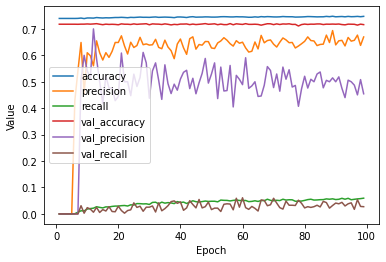

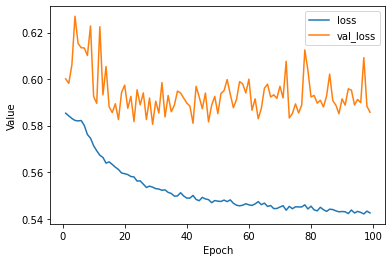

In [53]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 100
batch_size = 25
classification_threshold = 0.70
label_name = "label"

list_of_hyperparameters = [learning_rate, epochs, batch_size,
                           classification_threshold,
                           label_name]

# Here is the updated definition of METRICS:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(
          name='accuracy', threshold=classification_threshold),
      tf.keras.metrics.Precision(
          thresholds=classification_threshold, name='precision'),
      tf.keras.metrics.Recall(
          thresholds=classification_threshold, name="recall"),
]

# Establish the model's topography.
my_model = create_model(learning_rate, METRICS)

my_model.summary()

# Train the model on the training set.
epochs, hist = train_model(my_model, x_train, y_train, epochs, 
                          label_name, batch_size, validation_data=(x_val, y_val))

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall", 'val_accuracy', 'val_precision', 'val_recall'] 
plot_curve(epochs, hist, list_of_metrics_to_plot, 'example_dest_dir/training_rms_dnn/', filename, list_of_hyperparameters)
plot_curve(epochs, hist, ['loss', 'val_loss'], 'example_dest_dir/training_rms_dnn/', filename, list_of_hyperparameters)

training_performance =  my_model.evaluate(x_train, y_train, verbose=0)
print('Training Performance')
print('---------------------------------')
print('loss: ', training_performance[0])
print('accuracy: ', training_performance[1])
print('precision: ', training_performance[2])
print('recall: ', training_performance[3])
print()

validation_performance =  my_model.evaluate(x_val, y_val, verbose=0)
print('Validation Performance')
print('---------------------------------')
print('loss: ', validation_performance[0])
print('accuracy: ', validation_performance[1])
print('precision: ', validation_performance[2])
print('recall: ', validation_performance[3])

## Train 1
Deep Neural Network:
* Input Layer: 431 nodes
* Hidden Layer 1: 431 nodes
* Hidden Layer 2: 40 nodes
* Ouput Layer: 1 node

Hyper-parameters:
* Loss Function: BinaryCrossEntropy
* Activation Function: Relu
* Optimizer Function: RMSprop
* Learning Rate: 0.001 
* Epochs: 250
* Batch_Size: 25
* Classification Threshold: 0.7
* Regularization: L2
* Regularization Lambda: 0.05

In [54]:
# Define the functions that create and train a model.
def create_model(my_learning_rate, my_metrics):
    """Create and compile a simple classification model."""
    # Discard any pre-existing version of the model.
    model = None

    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()

    # Add the input layer of 431 nodes
    model.add(tf.keras.layers.Dense(units=431, input_shape=(431,)))
              
    # Implement L2 regularization in the first hidden layer.
    model.add(tf.keras.layers.Dense(units=431, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.05),
                                  name='Hidden1'))
    
    # Implement L2 regularization in the second hidden layer.
    model.add(tf.keras.layers.Dense(units=40, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.05),
                                  name='Hidden2'))

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid,
                                  name='Output'))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.  Notice that we're using a different loss
    # function for classification than for regression.    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

    return model        
              
def train_model(model, features, label, epochs, label_name,
                batch_size=None, my_validation_split=0.1,
                validation_data=None, shuffle=True):
    """Feed a dataset into the model in order to train it."""

    # The x parameter of tf.keras.Model.fit can be a list of arrays.
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle, validation_data=validation_data)

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # Isolate the classification metric for each epoch.
    hist = pd.DataFrame(history.history)

    return epochs, hist  

print("Defined the create_model and train_model functions.")  

Defined the create_model and train_model functions.


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 431)               186192    
_________________________________________________________________
Hidden1 (Dense)              (None, 431)               186192    
_________________________________________________________________
Hidden2 (Dense)              (None, 40)                17280     
_________________________________________________________________
Output (Dense)               (None, 1)                 41        
Total params: 389,705
Trainable params: 389,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
622/622 [==============================] - 2s 4ms/step - loss: 1.3547 - accuracy: 0.7396 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6058 - val_accuracy: 0.7177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoc

Epoch 32/250
622/622 [==============================] - 2s 3ms/step - loss: 0.5550 - accuracy: 0.7401 - precision: 0.8333 - recall: 0.0025 - val_loss: 0.5883 - val_accuracy: 0.7172 - val_precision: 0.3333 - val_recall: 0.0018
Epoch 33/250
622/622 [==============================] - 2s 3ms/step - loss: 0.5542 - accuracy: 0.7398 - precision: 0.6429 - recall: 0.0022 - val_loss: 0.5821 - val_accuracy: 0.7177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 34/250
622/622 [==============================] - 2s 4ms/step - loss: 0.5546 - accuracy: 0.7400 - precision: 0.8889 - recall: 0.0020 - val_loss: 0.5838 - val_accuracy: 0.7177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 35/250
622/622 [==============================] - 2s 4ms/step - loss: 0.5530 - accuracy: 0.7400 - precision: 0.6875 - recall: 0.0027 - val_loss: 0.6170 - val_accuracy: 0.7172 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 36/250
622/622 [==============================] - 2s 4ms/step - lo

622/622 [==============================] - 2s 3ms/step - loss: 0.5424 - accuracy: 0.7400 - precision: 0.7143 - recall: 0.0025 - val_loss: 0.6283 - val_accuracy: 0.7177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 68/250
622/622 [==============================] - 2s 3ms/step - loss: 0.5446 - accuracy: 0.7405 - precision: 0.9375 - recall: 0.0037 - val_loss: 0.5821 - val_accuracy: 0.7177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 69/250
622/622 [==============================] - 2s 4ms/step - loss: 0.5443 - accuracy: 0.7402 - precision: 0.7143 - recall: 0.0037 - val_loss: 0.5776 - val_accuracy: 0.7174 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 70/250
622/622 [==============================] - 2s 3ms/step - loss: 0.5424 - accuracy: 0.7400 - precision: 0.7692 - recall: 0.0025 - val_loss: 0.5894 - val_accuracy: 0.7185 - val_precision: 0.6667 - val_recall: 0.0055
Epoch 71/250
622/622 [==============================] - 3s 4ms/step - loss: 0.5420 - 

Epoch 103/250
622/622 [==============================] - 2s 3ms/step - loss: 0.5376 - accuracy: 0.7404 - precision: 0.7407 - recall: 0.0049 - val_loss: 0.5798 - val_accuracy: 0.7172 - val_precision: 0.4167 - val_recall: 0.0046
Epoch 104/250
622/622 [==============================] - 2s 3ms/step - loss: 0.5402 - accuracy: 0.7407 - precision: 0.6977 - recall: 0.0074 - val_loss: 0.5825 - val_accuracy: 0.7172 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 105/250
622/622 [==============================] - 2s 4ms/step - loss: 0.5386 - accuracy: 0.7403 - precision: 0.6875 - recall: 0.0054 - val_loss: 0.5789 - val_accuracy: 0.7172 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 106/250
622/622 [==============================] - 2s 3ms/step - loss: 0.5376 - accuracy: 0.7407 - precision: 0.7143 - recall: 0.0074 - val_loss: 0.5848 - val_accuracy: 0.7167 - val_precision: 0.2500 - val_recall: 0.0018
Epoch 107/250
622/622 [==============================] - 2s 4ms/step - loss:

Epoch 139/250
622/622 [==============================] - 2s 4ms/step - loss: 0.5341 - accuracy: 0.7409 - precision: 0.6923 - recall: 0.0089 - val_loss: 0.5832 - val_accuracy: 0.7177 - val_precision: 0.5000 - val_recall: 0.0091
Epoch 140/250
622/622 [==============================] - 2s 4ms/step - loss: 0.5368 - accuracy: 0.7406 - precision: 0.6667 - recall: 0.0079 - val_loss: 0.5872 - val_accuracy: 0.7172 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 141/250
622/622 [==============================] - 2s 4ms/step - loss: 0.5364 - accuracy: 0.7397 - precision: 0.5333 - recall: 0.0040 - val_loss: 0.5860 - val_accuracy: 0.7172 - val_precision: 0.4000 - val_recall: 0.0036
Epoch 142/250
622/622 [==============================] - 3s 4ms/step - loss: 0.5356 - accuracy: 0.7399 - precision: 0.5758 - recall: 0.0047 - val_loss: 0.5837 - val_accuracy: 0.7167 - val_precision: 0.3889 - val_recall: 0.0064
Epoch 143/250
622/622 [==============================] - 2s 3ms/step - loss: 0.5357 

Epoch 175/250
622/622 [==============================] - 2s 3ms/step - loss: 0.5371 - accuracy: 0.7406 - precision: 0.6818 - recall: 0.0074 - val_loss: 0.5904 - val_accuracy: 0.7177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 176/250
622/622 [==============================] - 2s 3ms/step - loss: 0.5336 - accuracy: 0.7400 - precision: 0.6129 - recall: 0.0047 - val_loss: 0.6061 - val_accuracy: 0.7172 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 177/250
622/622 [==============================] - 2s 3ms/step - loss: 0.5330 - accuracy: 0.7400 - precision: 0.6071 - recall: 0.0042 - val_loss: 0.5966 - val_accuracy: 0.7172 - val_precision: 0.4167 - val_recall: 0.0046
Epoch 178/250
622/622 [==============================] - 2s 3ms/step - loss: 0.5348 - accuracy: 0.7403 - precision: 0.6875 - recall: 0.0054 - val_loss: 0.5867 - val_accuracy: 0.7174 - val_precision: 0.4286 - val_recall: 0.0027
Epoch 179/250
622/622 [==============================] - 2s 3ms/step - loss:

Epoch 211/250
622/622 [==============================] - 2s 4ms/step - loss: 0.5337 - accuracy: 0.7408 - precision: 0.7209 - recall: 0.0077 - val_loss: 0.5860 - val_accuracy: 0.7162 - val_precision: 0.3333 - val_recall: 0.0055
Epoch 212/250
622/622 [==============================] - 2s 3ms/step - loss: 0.5327 - accuracy: 0.7414 - precision: 0.7188 - recall: 0.0114 - val_loss: 0.5887 - val_accuracy: 0.7169 - val_precision: 0.2857 - val_recall: 0.0018
Epoch 213/250
622/622 [==============================] - 2s 3ms/step - loss: 0.5330 - accuracy: 0.7404 - precision: 0.6757 - recall: 0.0062 - val_loss: 0.5861 - val_accuracy: 0.7177 - val_precision: 0.5000 - val_recall: 0.0046
Epoch 214/250
622/622 [==============================] - 2s 3ms/step - loss: 0.5319 - accuracy: 0.7401 - precision: 0.6053 - recall: 0.0057 - val_loss: 0.5838 - val_accuracy: 0.7164 - val_precision: 0.2222 - val_recall: 0.0018
Epoch 215/250
622/622 [==============================] - 2s 3ms/step - loss: 0.5329 - accura

Epoch 247/250
622/622 [==============================] - 2s 3ms/step - loss: 0.5297 - accuracy: 0.7399 - precision: 0.6087 - recall: 0.0035 - val_loss: 0.5854 - val_accuracy: 0.7172 - val_precision: 0.3750 - val_recall: 0.0027
Epoch 248/250
622/622 [==============================] - 2s 3ms/step - loss: 0.5324 - accuracy: 0.7405 - precision: 0.7419 - recall: 0.0057 - val_loss: 0.5925 - val_accuracy: 0.7169 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 249/250
622/622 [==============================] - 3s 4ms/step - loss: 0.5309 - accuracy: 0.7402 - precision: 0.6667 - recall: 0.0049 - val_loss: 0.5850 - val_accuracy: 0.7172 - val_precision: 0.2500 - val_recall: 9.1158e-04
Epoch 250/250
622/622 [==============================] - 3s 4ms/step - loss: 0.5312 - accuracy: 0.7406 - precision: 0.7500 - recall: 0.0059 - val_loss: 0.5842 - val_accuracy: 0.7180 - val_precision: 0.5385 - val_recall: 0.0064
Training Performance
---------------------------------
loss:  0.5262638330459595

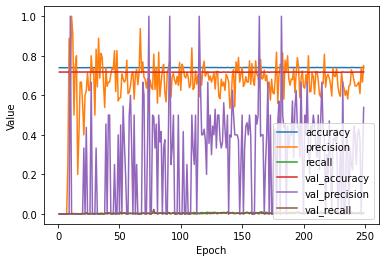

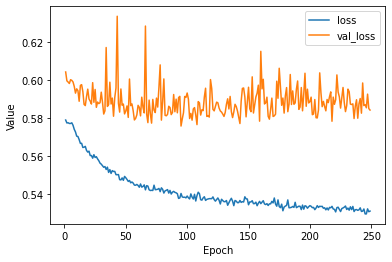

In [55]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 250
batch_size = 25
classification_threshold = 0.70
label_name = "label"

list_of_hyperparameters = [learning_rate, epochs, batch_size,
                           classification_threshold,
                           label_name]

# Here is the updated definition of METRICS:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(
          name='accuracy', threshold=classification_threshold),
      tf.keras.metrics.Precision(
          thresholds=classification_threshold, name='precision'),
      tf.keras.metrics.Recall(
          thresholds=classification_threshold, name="recall"),
]

# Establish the model's topography.
my_model = create_model(learning_rate, METRICS)

my_model.summary()

# Train the model on the training set.
epochs, hist = train_model(my_model, x_train, y_train, epochs, 
                          label_name, batch_size, validation_data=(x_val, y_val))

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall", 'val_accuracy', 'val_precision', 'val_recall'] 
plot_curve(epochs, hist, list_of_metrics_to_plot, 'example_dest_dir/training_rms_dnn/', filename, list_of_hyperparameters)
plot_curve(epochs, hist, ['loss', 'val_loss'], 'example_dest_dir/training_rms_dnn/', filename, list_of_hyperparameters)

training_performance =  my_model.evaluate(x_train, y_train, verbose=0)
print('Training Performance')
print('---------------------------------')
print('loss: ', training_performance[0])
print('accuracy: ', training_performance[1])
print('precision: ', training_performance[2])
print('recall: ', training_performance[3])
print()

validation_performance =  my_model.evaluate(x_val, y_val, verbose=0)
print('Validation Performance')
print('---------------------------------')
print('loss: ', validation_performance[0])
print('accuracy: ', validation_performance[1])
print('precision: ', validation_performance[2])
print('recall: ', validation_performance[3])

## Train 2
Deep Neural Network:
* Input Layer: 431 nodes
* Hidden Layer 1: 431 nodes
* Hidden Layer 2: 40 nodes
* Hidden Layer 3: 20 nodes
* Ouput Layer: 1 node

Hyper-parameters:
* Loss Function: BinaryCrossEntropy
* Activation Function: Relu
* Optimizer Function: RMSprop
* Learning Rate: 0.001 
* Epochs: 200
* Batch_Size: 25
* Classification Threshold: 0.7
* Regularization: L2
* Regularization Lambda: 0.05

In [56]:
# Define the functions that create and train a model.
def create_model(my_learning_rate, my_metrics):
    """Create and compile a simple classification model."""
    # Discard any pre-existing version of the model.
    model = None

    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()

    # Add the input layer of 431 nodes
    model.add(tf.keras.layers.Dense(units=431, input_shape=(431,)))
              
    # Implement L2 regularization in the first hidden layer.
    model.add(tf.keras.layers.Dense(units=431, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.05),
                                  name='Hidden1'))
    
    # Implement L2 regularization in the second hidden layer.
    model.add(tf.keras.layers.Dense(units=40, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.05),
                                  name='Hidden2'))
    
    # Implement L2 regularization in the third hidden layer.
    model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.05),
                                  name='Hidden3'))

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid,
                                  name='Output'))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.  Notice that we're using a different loss
    # function for classification than for regression.    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

    return model        
              
def train_model(model, features, label, epochs, label_name,
                batch_size=None, my_validation_split=0.1,
                validation_data=None, shuffle=True):
    """Feed a dataset into the model in order to train it."""

    # The x parameter of tf.keras.Model.fit can be a list of arrays.
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle, validation_data=validation_data)

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # Isolate the classification metric for each epoch.
    hist = pd.DataFrame(history.history)

    return epochs, hist  

print("Defined the create_model and train_model functions.")  

Defined the create_model and train_model functions.


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 431)               186192    
_________________________________________________________________
Hidden1 (Dense)              (None, 431)               186192    
_________________________________________________________________
Hidden2 (Dense)              (None, 40)                17280     
_________________________________________________________________
Hidden3 (Dense)              (None, 20)                820       
_________________________________________________________________
Output (Dense)               (None, 1)                 21        
Total params: 390,505
Trainable params: 390,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
311/311 [==============================] - 2s 5ms/step - loss: 1.4257 - accuracy: 0.7396 - precision:

Epoch 31/200
311/311 [==============================] - 1s 4ms/step - loss: 0.5839 - accuracy: 0.7396 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6059 - val_accuracy: 0.7177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 32/200
311/311 [==============================] - 1s 4ms/step - loss: 0.5839 - accuracy: 0.7396 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6061 - val_accuracy: 0.7177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 33/200
311/311 [==============================] - 1s 4ms/step - loss: 0.5840 - accuracy: 0.7396 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6060 - val_accuracy: 0.7177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 34/200
311/311 [==============================] - 1s 4ms/step - loss: 0.5840 - accuracy: 0.7396 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6076 - val_accuracy: 0.7177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 35/200
311/311 [==========

Epoch 65/200
311/311 [==============================] - 1s 4ms/step - loss: 0.5840 - accuracy: 0.7396 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6067 - val_accuracy: 0.7177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 66/200
311/311 [==============================] - 1s 4ms/step - loss: 0.5839 - accuracy: 0.7396 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6055 - val_accuracy: 0.7177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 67/200
311/311 [==============================] - 1s 4ms/step - loss: 0.5839 - accuracy: 0.7396 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6060 - val_accuracy: 0.7177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 68/200
311/311 [==============================] - 1s 4ms/step - loss: 0.5840 - accuracy: 0.7396 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6063 - val_accuracy: 0.7177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 69/200
311/311 [==========

Epoch 99/200
311/311 [==============================] - 2s 5ms/step - loss: 0.5839 - accuracy: 0.7396 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6054 - val_accuracy: 0.7177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 100/200
311/311 [==============================] - 1s 5ms/step - loss: 0.5838 - accuracy: 0.7396 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6062 - val_accuracy: 0.7177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 101/200
311/311 [==============================] - 1s 4ms/step - loss: 0.5839 - accuracy: 0.7396 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6069 - val_accuracy: 0.7177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 102/200
311/311 [==============================] - 1s 4ms/step - loss: 0.5840 - accuracy: 0.7396 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6061 - val_accuracy: 0.7177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 103/200
311/311 [======

Epoch 133/200
311/311 [==============================] - 1s 4ms/step - loss: 0.5839 - accuracy: 0.7396 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6061 - val_accuracy: 0.7177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 134/200
311/311 [==============================] - 1s 4ms/step - loss: 0.5838 - accuracy: 0.7396 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6074 - val_accuracy: 0.7177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 135/200
311/311 [==============================] - 1s 4ms/step - loss: 0.5839 - accuracy: 0.7396 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6065 - val_accuracy: 0.7177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 136/200
311/311 [==============================] - 1s 4ms/step - loss: 0.5838 - accuracy: 0.7396 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6078 - val_accuracy: 0.7177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 137/200
311/311 [=====

Epoch 167/200
311/311 [==============================] - 1s 4ms/step - loss: 0.5839 - accuracy: 0.7396 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6066 - val_accuracy: 0.7177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 168/200
311/311 [==============================] - 1s 4ms/step - loss: 0.5840 - accuracy: 0.7396 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6061 - val_accuracy: 0.7177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 169/200
311/311 [==============================] - 1s 3ms/step - loss: 0.5839 - accuracy: 0.7396 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6072 - val_accuracy: 0.7177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 170/200
311/311 [==============================] - 1s 4ms/step - loss: 0.5839 - accuracy: 0.7396 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6058 - val_accuracy: 0.7177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 171/200
311/311 [=====

Training Performance
---------------------------------
loss:  0.5838065147399902
accuracy:  0.7395752668380737
precision:  0.0
recall:  0.0

Validation Performance
---------------------------------
loss:  0.6074568033218384
accuracy:  0.7177045941352844
precision:  0.0
recall:  0.0


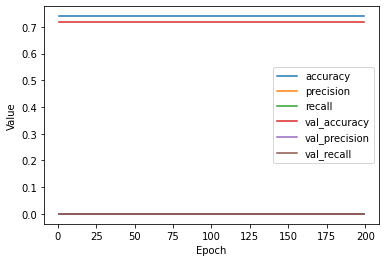

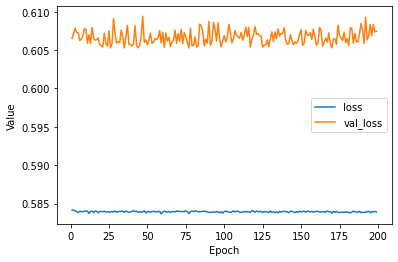

In [57]:
# The following variables are the hyperparameters.
learning_rate = 0.002
epochs = 200
batch_size = 50
classification_threshold = 0.70
label_name = "label"

list_of_hyperparameters = [learning_rate, epochs, batch_size,
                           classification_threshold,
                           label_name]

# Here is the updated definition of METRICS:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(
          name='accuracy', threshold=classification_threshold),
      tf.keras.metrics.Precision(
          thresholds=classification_threshold, name='precision'),
      tf.keras.metrics.Recall(
          thresholds=classification_threshold, name="recall"),
]

# Establish the model's topography.
my_model = create_model(learning_rate, METRICS)

# Print the models structure
my_model.summary()

# Train the model on the training set.
epochs, hist = train_model(my_model, x_train, y_train, epochs, 
                          label_name, batch_size, validation_data=(x_val, y_val))

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall", 'val_accuracy', 'val_precision', 'val_recall'] 
plot_curve(epochs, hist, list_of_metrics_to_plot, 'example_dest_dir/training_rms_dnn/', filename, list_of_hyperparameters)
plot_curve(epochs, hist, ['loss', 'val_loss'], 'example_dest_dir/training_rms_dnn/', filename, list_of_hyperparameters)

training_performance =  my_model.evaluate(x_train, y_train, verbose=0)
print('Training Performance')
print('---------------------------------')
print('loss: ', training_performance[0])
print('accuracy: ', training_performance[1])
print('precision: ', training_performance[2])
print('recall: ', training_performance[3])
print()

validation_performance =  my_model.evaluate(x_val, y_val, verbose=0)
print('Validation Performance')
print('---------------------------------')
print('loss: ', validation_performance[0])
print('accuracy: ', validation_performance[1])
print('precision: ', validation_performance[2])
print('recall: ', validation_performance[3])